In [17]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep

In [ ]:
X_train= pd.read_csv('/media/Z/NDT/Transformer_Tabular/dataset/train.csv')
X_val=pd.read_csv('/media/Z/NDT/Transformer_Tabular/dataset/val.csv')
test_data=pd.read_csv('/media/Z/NDT/Transformer_Tabular/dataset/test.csv')

In [19]:
# CATEGORICAL_FEATURES=['workclass', 'education', 'marital_status', 'occupation',
#        'relationship', 'race', 'gender', 'native_country']
# NUMERIC_FEATURES=['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
#        'hours_per_week']
# LABEL = 'income_bracket'

In [20]:
CATEGORICAL_FEATURES=['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'gender', 'native_country']
NUMERIC_FEATURES=['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week']
LABEL = 'income_bracket'

In [21]:
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [22]:
# To TF Dataset
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [23]:
train_dataset

<PrefetchDataset element_spec=({'workclass': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'education': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'marital_status': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'occupation': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'relationship': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'race': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'native_country': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'age': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'fnlwgt': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'education_num': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'capital_gain': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'capital_loss': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'hours_per_week': TensorSpec(shape=(None, 1), 

In [24]:
val_dataset

<PrefetchDataset element_spec=({'workclass': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'education': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'marital_status': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'occupation': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'relationship': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'race': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'native_country': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'age': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'fnlwgt': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'education_num': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'capital_gain': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'capital_loss': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'hours_per_week': TensorSpec(shape=(None, 1), 

In [12]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=3,
    heads=6,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=True
)

In [13]:
# Pass the encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation='sigmoid',
)

In [14]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 2

In [15]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]


In [16]:
ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/2
51/51 [==============================] - 8s 70ms/step - loss: 0.4042 - output_loss: 0.4042 - output_PR AUC: 0.6065 - val_loss: 0.3585 - val_output_loss: 0.3585 - val_output_PR AUC: 0.7122
Epoch 2/2
51/51 [==============================] - 3s 60ms/step - loss: 0.3517 - output_loss: 0.3517 - output_PR AUC: 0.7104 - val_loss: 0.3500 - val_output_loss: 0.3500 - val_output_PR AUC: 0.7155


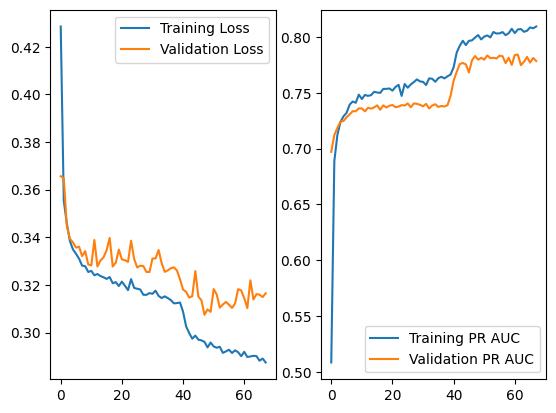

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
ax[1].legend()

plt.show()


In [12]:
linear_test_preds = ft_linear_transformer.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], linear_test_preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

32/32 [==============================] - 1s 26ms/step
FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.9094
Test PR AUC: 0.7777
Test Accuracy: 0.8579


# explainable

In [13]:
linear_importances = linear_test_preds['importances']
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)

In [14]:
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)
    
    plt.figure(figsize=(15,7))
    ax = imps_sorted.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()
    
    return imps_sorted

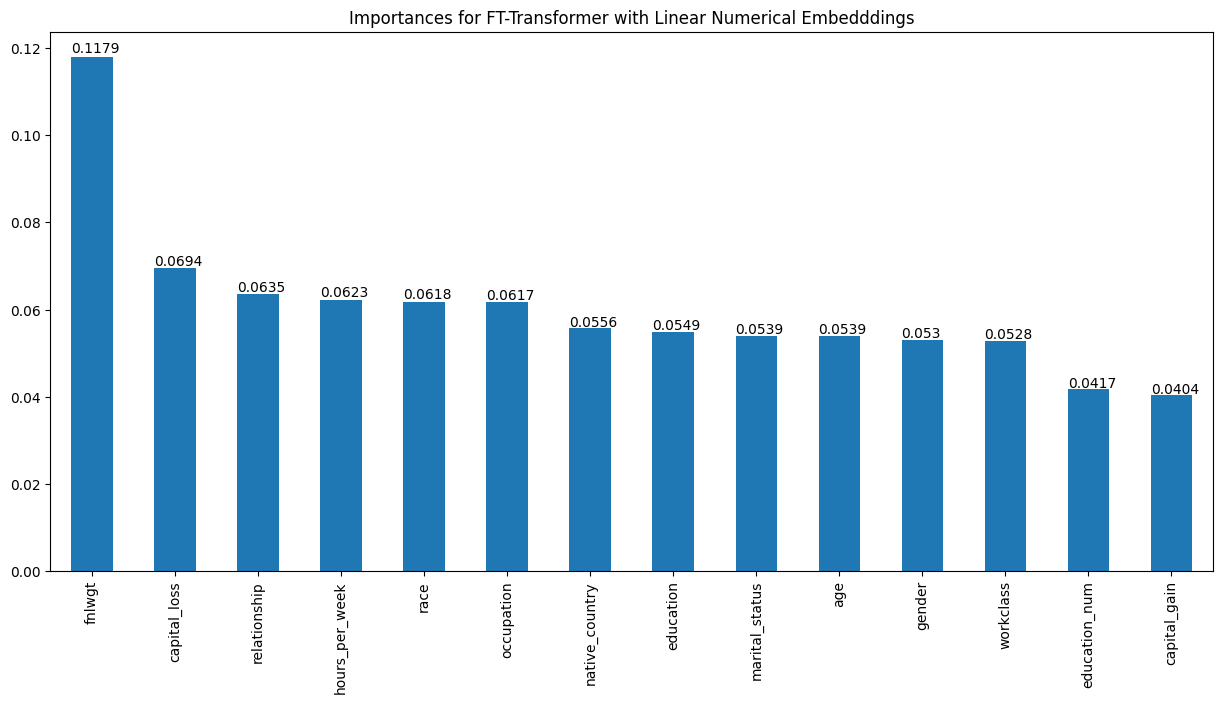

In [15]:
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [16]:
# Largest prediction
max_idx = np.argsort(linear_test_preds['output'].ravel())[-1]
example_importance_linear = linear_importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[max_idx, :].rename("Example Value")
).head(5)
print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[max_idx], 4))}")
display(example_importance_linear)

# Smallest one
min_idx = np.argsort(linear_test_preds['output'].ravel())[0]
example_importance_linear = linear_importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[min_idx, :].rename("Example Value")
).head(5)
print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[min_idx], 4))}")
display(example_importance_linear)

Top 5 contributions to row 9185 which was scored 0.9905


,Importance,Example Value
capital_loss,0.244144,0
fnlwgt,0.160304,473133
marital_status,0.078462,Married-civ-spouse
occupation,0.045951,Prof-specialty
education_num,0.043550,16


Top 5 contributions to row 14599 which was scored 0.0006


,Importance,Example Value
gender,0.084707,Female
race,0.080817,Other
workclass,0.070852,Private
relationship,0.068499,Other-relative
occupation,0.068384,Sales
